In [29]:
import os
import numpy as np
from PIL import Image, ImageSequence
import cv2
from scipy.ndimage import median_filter
from skimage import filters, exposure
import tifffile as tiff

def denoise_stack_all_methods(input_path, output_path, gaussian_sigma=1.0, median_size=3, fusion_method='max'):
    frames = []

    with Image.open(input_path) as img:
        for i, frame in enumerate(ImageSequence.Iterator(img)):
            # Convert to numpy array
            image = np.array(frame)

            # Track original intensity range
            image_min, image_max = np.min(image), np.max(image)

            # Step 1: Median filter
            image = median_filter(image, size=median_size)

            # Step 2: Gaussian filter
            image = filters.gaussian(image, sigma=gaussian_sigma, preserve_range=True)

            # Step 3: Normalize for bilateral filtering
            image_norm = (image - image_min) / (image_max - image_min)
            image_norm = image_norm.astype(np.float32)

            # Parameters for bilateral filter
            height, width = image.shape[:2]
            d = max(5, min(height, width) // 50)
            sigmaColor = np.std(image_norm) * 0.15
            sigmaSpace = d * 1

            # Step 4: Bilateral filter (on normalized float32)
            image_filtered = cv2.bilateralFilter(image_norm, d, sigmaColor, sigmaSpace)

            # Denormalize and clip
            image_filtered = image_filtered * (image_max - image_min) + image_min
            image_filtered = np.clip(image_filtered, 0, 65535)

            # Auto-detect output dtype
            if image_max > 255:
                out_dtype = np.uint16
            else:
                out_dtype = np.uint8

            # Convert to final format
            final_frame = image_filtered.astype(out_dtype)
            frames.append(final_frame)

            print(f"Processed slice {i+1}/{img.n_frames}")

    # Stack frames for fusion
    image_stack = np.array(frames)

    # Apply fusion method
    if fusion_method == 'max':
        # Maximum intensity projection (MIP) fusion
        fused_image = np.max(image_stack, axis=0)
    elif fusion_method == 'sum':
        # Sum fusion
        fused_image = np.sum(image_stack, axis=0)
        # Clip to valid range
        fused_image = np.clip(fused_image, 0, 65535)
    elif fusion_method == 'average':
        # Average fusion
        fused_image = np.mean(image_stack, axis=0)
        # Clip to valid range
        fused_image = np.clip(fused_image, 0, 65535)
    else:
        raise ValueError("Unknown fusion method. Use 'max', 'sum', or 'average'.")

    # Convert to output format
    fused_image = fused_image.astype(np.uint16) if np.max(fused_image) > 255 else fused_image.astype(np.uint8)

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save the fused image
    Image.fromarray(fused_image).save(output_path)
    print(f"Saved fused image to: {output_path}")

# Example usage
input_path = r"C:\Bio\image_177_nucleus_angle.tif"
output_path = r"C:\Bio\image_177_nucleus_denoised.tif"
denoise_stack_all_methods(input_path, output_path, fusion_method='max')  # Change fusion_method as needed


Processed slice 1/891
Processed slice 2/891
Processed slice 3/891
Processed slice 4/891
Processed slice 5/891
Processed slice 6/891
Processed slice 7/891
Processed slice 8/891
Processed slice 9/891
Processed slice 10/891
Processed slice 11/891
Processed slice 12/891
Processed slice 13/891
Processed slice 14/891
Processed slice 15/891
Processed slice 16/891
Processed slice 17/891
Processed slice 18/891
Processed slice 19/891
Processed slice 20/891
Processed slice 21/891
Processed slice 22/891
Processed slice 23/891
Processed slice 24/891
Processed slice 25/891
Processed slice 26/891
Processed slice 27/891
Processed slice 28/891
Processed slice 29/891
Processed slice 30/891
Processed slice 31/891
Processed slice 32/891
Processed slice 33/891
Processed slice 34/891
Processed slice 35/891
Processed slice 36/891
Processed slice 37/891
Processed slice 38/891
Processed slice 39/891
Processed slice 40/891
Processed slice 41/891
Processed slice 42/891
Processed slice 43/891
Processed slice 44/8

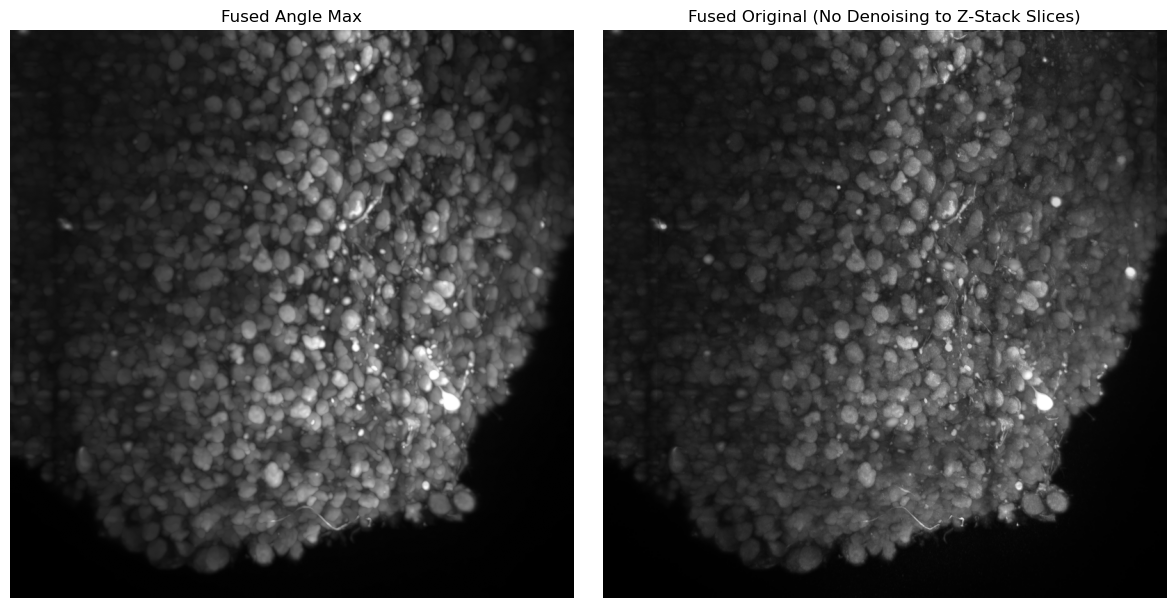

In [24]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_side_by_side(image_path1, image_path2, title1='Image 1', title2='Image 2'):
    # Load images and convert to numpy arrays
    image1 = np.array(Image.open(image_path1))
    image2 = np.array(Image.open(image_path2))

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Show first image
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(title1)
    axes[0].axis('off')

    # Show second image
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(title2)
    axes[1].axis('off')

    # Show the full plot
    plt.tight_layout()
    plt.show()

# Example usage
image_path1 = r"C:\Bio\image_169_nucleus_fused_denoised.tif"
image_path2 = r"C:\Bio\image_169_nucleus_fused_merged.png"
show_side_by_side(image_path1, image_path2, title1='Fused Angle Max', title2='Fused Original (No Denoising to Z-Stack Slices)')
